In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
ncd_data = pd.read_csv('/content/drive/MyDrive/Dissertation/processed_ncd_data.csv')
print("NCD temporal data loaded: ", ncd_data.shape)

NCD temporal data loaded:  (13200, 4)


In [3]:
print('Diabetes Prevalence Statistics:')
print(f"Average: {ncd_data['prevalence'].mean():.1f}%")
print(f"Minimum: {ncd_data['prevalence'].min():.1f}%")
print(f"Maximum: {ncd_data['prevalence'].max():.1f}%")

Diabetes Prevalence Statistics:
Average: 0.1%
Minimum: 0.0%
Maximum: 0.4%


In [4]:
def calculate_mape(actual, predicted):
    actual = np.where(actual == 0, 0.01, actual)
    errors = np.abs(actual - predicted) / actual
    return errors.mean() * 100

In [5]:
def prepare_sequences(data, seq_length):
    data = data.sort_values('year').reset_index(drop=True)

    if len(data) <= seq_length:
        return None, None

    X, y = [], []

    for i in range(len(data) - seq_length):
        seq = data['prevalence'].iloc[i : i + seq_length].values
        target = data['prevalence'].iloc[i + seq_length]
        X.append(seq)
        y.append(target)

    return np.array(X), np.array(y)

In [6]:
def prepare_country_data(country_data, seq_length=5, test_size=2):
    if len(country_data) <= seq_length + test_size:
        return None

    country_data = country_data.sort_values('year').reset_index(drop=True)
    country_data = country_data.dropna(subset=['prevalence'])

    # Sequences for LSTM
    X, y = prepare_sequences(country_data, seq_length)
    if X is None or len(X) <= test_size:
        return None

    split_point = len(X) - test_size
    X_train = X[:split_point]
    y_train = y[:split_point]
    X_test = X[split_point:]
    y_test = y[split_point:]

    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'country_data': country_data,
        'seq_length': seq_length
    }

In [7]:
print("Processing All Countries and Genders")

seq_length = 6
test_size = 2
min_years = 12

print("Sequence length: ", seq_length, "years")
print("Test size: ", test_size, "years")
print("Minimum data required: ", min_years, "years")

# All country-gender combinations
all_combinations = []
for country in ncd_data['country'].unique():
    for gender in ncd_data['gender'].unique():
        subset = ncd_data[(ncd_data['country'] == country) & (ncd_data['gender'] == gender)]
        if len(subset) >= min_years:
            all_combinations.append((country, gender))

print("\nTotal combinations to process: ", len(all_combinations))

processed_data = {}
all_training_data = {'X_train': [], 'y_train': [], 'X_test': [], 'y_test': []}
successful_count = 0

for country, gender in all_combinations:
    subset = ncd_data[(ncd_data['country'] == country) & (ncd_data['gender'] == gender)]
    result = prepare_country_data(subset, seq_length, test_size)

    if result is not None:
        key = country + '_' + gender
        processed_data[key] = result

        # Adding to the combined dataset
        all_training_data['X_train'].extend(result['X_train'])
        all_training_data['y_train'].extend(result['y_train'])
        all_training_data['X_test'].extend(result['X_test'])
        all_training_data['y_test'].extend(result['y_test'])

X_train_all = np.array(all_training_data['X_train'])
y_train_all = np.array(all_training_data['y_train'])
X_test_all = np.array(all_training_data['X_test'])
y_test_all = np.array(all_training_data['y_test'])

print("Successfully processed", len(processed_data), "/", len(all_combinations), "combinations")
print("Training data shape:", X_train_all.shape)
print("Test data shape:", X_test_all.shape)

Processing All Countries and Genders
Sequence length:  6 years
Test size:  2 years
Minimum data required:  12 years

Total combinations to process:  400
Successfully processed 400 / 400 combinations
Training data shape: (10000, 6)
Test data shape: (800, 6)


In [8]:
def build_lstm_model(seq_length, n_features):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, n_features)),
        LSTM(25, return_sequences=False),
        Dense(10, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

if len(X_train_all.shape) == 2:
    X_train_all = X_train_all.reshape(X_train_all.shape[0], X_train_all.shape[1], 1)
    X_test_all = X_test_all.reshape(X_test_all.shape[0], X_test_all.shape[1], 1)
    n_features = 1
else:
    n_features = X_train_all.shape[2]

model = build_lstm_model(seq_length, n_features)

print("Input shape: ", X_train_all.shape)
print("Features: ", n_features)

model.summary()

Input shape:  (10000, 6, 1)
Features:  1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,271 (71.37 KB)

 Trainable params: 18,271 (71.37 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
print("Training samples: ", len(X_train_all))
print("Test samples: ", len(X_test_all))

history = model.fit(
    X_train_all, y_train_all,
    validation_data=(X_test_all, y_test_all),
    epochs=50,
    batch_size=32,
    verbose=1
)

print("Training completed!")

Training samples:  10000
Test samples:  800
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0045 - mae: 0.0403 - val_loss: 1.2184e-04 - val_mae: 0.0077
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.2264e-05 - mae: 0.0050 - val_loss: 1.2260e-04 - val_mae: 0.0078
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.0356e-05 - mae: 0.0049 - val_loss: 1.0864e-04 - val_mae: 0.0073
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.6838e-05 - mae: 0.0048 - val_loss: 1.0342e-04 - val_mae: 0.0074
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3237e-05 - mae: 0.0046 - val_loss: 8.8839e-05 - val_mae: 0.0067
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.6693e-05 - mae: 0.0042 - val_loss: 6.4811e-05 - val_mae: 0.0057
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.1245e-05 - mae: 0.0040 - val_loss: 3.6338e-05 - val_mae: 0.0044
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.6102e-05 - mae

In [10]:
train_pred = model.predict(X_train_all, verbose=0)
test_pred = model.predict(X_test_all, verbose=0)

train_mse = mean_squared_error(y_train_all, train_pred.flatten())
train_mae = mean_absolute_error(y_train_all, train_pred.flatten())
train_mape = calculate_mape(y_train_all, train_pred.flatten())

test_mse = mean_squared_error(y_test_all, test_pred.flatten())
test_mae = mean_absolute_error(y_test_all, test_pred.flatten())
test_mape = calculate_mape(y_test_all, test_pred.flatten())

print("Training Results:")
print(f"  MSE: {train_mse:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  MAPE: {train_mape:.2f}%")

print("\nTest Results:")
print(f"  MSE: {test_mse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  MAPE: {test_mape:.2f}%")

Training Results:
  MSE: 0.0000
  MAE: 0.0002
  MAPE: 0.24%

Test Results:
  MSE: 0.0000
  MAE: 0.0001
  MAPE: 0.10%


In [11]:
print("Data ranges:")
print(f"y_train range: {y_train_all.min():.4f} to {y_train_all.max():.4f}")
print(f"y_test range: {y_test_all.min():.4f} to {y_test_all.max():.4f}")
print(f"Predictions range: {test_pred.min():.4f} to {test_pred.max():.4f}")

print(f"\nSample actual vs predicted:")
for i in range(5):
    print(f"Actual: {y_test_all[i]:.4f}, Predicted: {test_pred[i][0]:.4f}")

Data ranges:
y_train range: 0.0188 to 0.3691
y_test range: 0.0179 to 0.3407
Predictions range: 0.0179 to 0.3409

Sample actual vs predicted:
Actual: 0.2189, Predicted: 0.2187
Actual: 0.2253, Predicted: 0.2252
Actual: 0.2683, Predicted: 0.2678
Actual: 0.2784, Predicted: 0.2779
Actual: 0.1184, Predicted: 0.1185


In [12]:
# Test on the first 10 countries
sample_countries = list(processed_data.keys())[:10]
country_results = []

for country_key in sample_countries:
    data = processed_data[country_key]

    X_test_country = data['X_test']
    y_test_country = data['y_test']

    if len(X_test_country) == 0:
        continue

    print('Original shape for ', country_key, ':', X_test_country.shape)

    if len(X_test_country.shape) == 2:
        X_test_country = X_test_country.reshape(X_test_country.shape[0], X_test_country.shape[1], 1)

    print('Reshaped to: ', X_test_country.shape)

    predictions = model.predict(X_test_country, verbose=0).flatten()

    mse = mean_squared_error(y_test_country, predictions)
    mae = mean_absolute_error(y_test_country, predictions)
    mape = calculate_mape(y_test_country, predictions)

    country_results.append({
        'country': country_key,
        'mse': mse,
        'mae': mae,
        'mape': mape
    })

    print(f"{country_key}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print()

if country_results:
    avg_mse = np.mean([r['mse'] for r in country_results])
    avg_mae = np.mean([r['mae'] for r in country_results])
    avg_mape = np.mean([r['mape'] for r in country_results])

    print("Average Performance Across Countries:")
    print(f"  MSE: {avg_mse:.4f}")
    print(f"  MAE: {avg_mae:.4f}")
    print(f"  MAPE: {avg_mape:.2f}%")

Original shape for  afghanistan_men : (2, 6)
Reshaped to:  (2, 6, 1)
afghanistan_men:
  MSE: 0.0000
  MAE: 0.0001
  MAPE: 0.05%

Original shape for  afghanistan_women : (2, 6)
Reshaped to:  (2, 6, 1)
afghanistan_women:
  MSE: 0.0000
  MAE: 0.0005
  MAPE: 0.19%

Original shape for  albania_men : (2, 6)
Reshaped to:  (2, 6, 1)
albania_men:
  MSE: 0.0000
  MAE: 0.0001
  MAPE: 0.07%

Original shape for  albania_women : (2, 6)
Reshaped to:  (2, 6, 1)
albania_women:
  MSE: 0.0000
  MAE: 0.0001
  MAPE: 0.10%

Original shape for  algeria_men : (2, 6)
Reshaped to:  (2, 6, 1)
algeria_men:
  MSE: 0.0000
  MAE: 0.0003
  MAPE: 0.16%

Original shape for  algeria_women : (2, 6)
Reshaped to:  (2, 6, 1)
algeria_women:
  MSE: 0.0000
  MAE: 0.0003
  MAPE: 0.17%

Original shape for  american samoa_men : (2, 6)
Reshaped to:  (2, 6, 1)
american samoa_men:
  MSE: 0.0000
  MAE: 0.0006
  MAPE: 0.21%

Original shape for  american samoa_women : (2, 6)
Reshaped to:  (2, 6, 1)
american samoa_women:
  MSE: 0.0000
 

In [13]:
# Forecast for selected countries
representative_countries = {
    'united states of america_men': 'High-Income',
    'germany_women': 'High-Income',
    'brazil_men': 'Upper-Middle-Income',
    'india_women': 'Lower-Middle-Income',
    'nigeria_men': 'Low-Income'
}

country_results = []

for country_key in representative_countries.keys():
    data = processed_data[country_key]
    X_test_country = data['X_test']
    y_test_country = data['y_test']

    if len(X_test_country) == 0:
        print(f"No test data for {country_key}, skipping.")
        continue

    print('Original shape for ', country_key, ':', X_test_country.shape)

    if len(X_test_country.shape) == 2:
        X_test_country = X_test_country.reshape(X_test_country.shape[0], X_test_country.shape[1], 1)

    print('Reshaped to: ', X_test_country.shape)

    predictions = model.predict(X_test_country, verbose=0).flatten()

    mse = mean_squared_error(y_test_country, predictions)
    mae = mean_absolute_error(y_test_country, predictions)
    mape = calculate_mape(y_test_country, predictions)

    country_results.append({
        'country': country_key,
        'income_group': representative_countries[country_key],
        'mse': mse,
        'mae': mae,
        'mape': mape
    })

    print(country_key + " (" + representative_countries[country_key] + "):")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print()

Original shape for  united states of america_men : (2, 6)
Reshaped to:  (2, 6, 1)
united states of america_men (High-Income):
  MSE: 0.0000
  MAE: 0.0001
  MAPE: 0.07%

Original shape for  germany_women : (2, 6)
Reshaped to:  (2, 6, 1)
germany_women (High-Income):
  MSE: 0.0000
  MAE: 0.0000
  MAPE: 0.09%

Original shape for  brazil_men : (2, 6)
Reshaped to:  (2, 6, 1)
brazil_men (Upper-Middle-Income):
  MSE: 0.0000
  MAE: 0.0001
  MAPE: 0.10%

Original shape for  india_women : (2, 6)
Reshaped to:  (2, 6, 1)
india_women (Lower-Middle-Income):
  MSE: 0.0000
  MAE: 0.0001
  MAPE: 0.05%

Original shape for  nigeria_men : (2, 6)
Reshaped to:  (2, 6, 1)
nigeria_men (Low-Income):
  MSE: 0.0000
  MAE: 0.0001
  MAPE: 0.09%



In [14]:
def forecast_future(model, data, years_ahead=8):
    seq = data['X_test'][-1].reshape(1, -1, 1)  # reshape in one step
    forecasts = []

    for _ in range(years_ahead):
        pred = model.predict(seq, verbose=0)[0][0]
        forecasts.append(pred)
        next_seq = np.roll(seq[0], -1, axis=0)
        next_seq[-1] = pred
        seq = next_seq.reshape(1, next_seq.shape[0], next_seq.shape[1])

    return forecasts

In [16]:
forecast_results = []

for country_key, income_group in representative_countries.items():
    data = processed_data[country_key]
    forecasts = forecast_future(model, data, years_ahead=8)

    start_value = forecasts[0]
    end_value = forecasts[7]
    increase_pct = ((end_value - start_value) / start_value) * 100

    forecast_results.append({
        'Country': country_key.split('_')[0],
        'Income Group': income_group,
        '2023': start_value,
        '2026': forecasts[3],
        '2028': forecasts[5],
        '2030': end_value,
        'Increase (%)': increase_pct
    })

print("Country\tIncome\t2023\t2030\tIncrease(%)")
for res in forecast_results:
    print(f"{res['Country']}\t{res['Income Group']}\t{res['2023']:.2f}\t{res['2030']:.2f}\t{res['Increase (%)']:.1f}")

Country	Income	2023	2030	Increase(%)
united states of america	High-Income	0.14	0.16	20.7
germany	High-Income	0.05	0.06	14.5
brazil	Upper-Middle-Income	0.12	0.15	29.1
india	Lower-Middle-Income	0.24	0.30	25.7
nigeria	Low-Income	0.11	0.14	33.2


In [17]:
avg_rmse = np.sqrt(avg_mse)

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average MAPE: {avg_mape:.2f}%")

print("\nPerformance Assessment:")
if avg_mape < 15:
    print("Model performance: Excellent (MAPE < 15%)")
elif avg_mape < 25:
    print("Model performance: Good (MAPE < 25%)")
else:
    print("Model performance: Needs improvement (MAPE >= 25%)")

print(f"\nInterpretation:")
print(f"- On average, predictions are off by {avg_mae:.2f} percentage points")
print(f"- Model explains diabetes prevalence trends with {avg_mape:.1f}% average error")

Average MSE: 0.0000
Average MAE: 0.0003
Average RMSE: 0.0003
Average MAPE: 0.12%

Performance Assessment:
Model performance: Excellent (MAPE < 15%)

Interpretation:
- On average, predictions are off by 0.00 percentage points
- Model explains diabetes prevalence trends with 0.1% average error


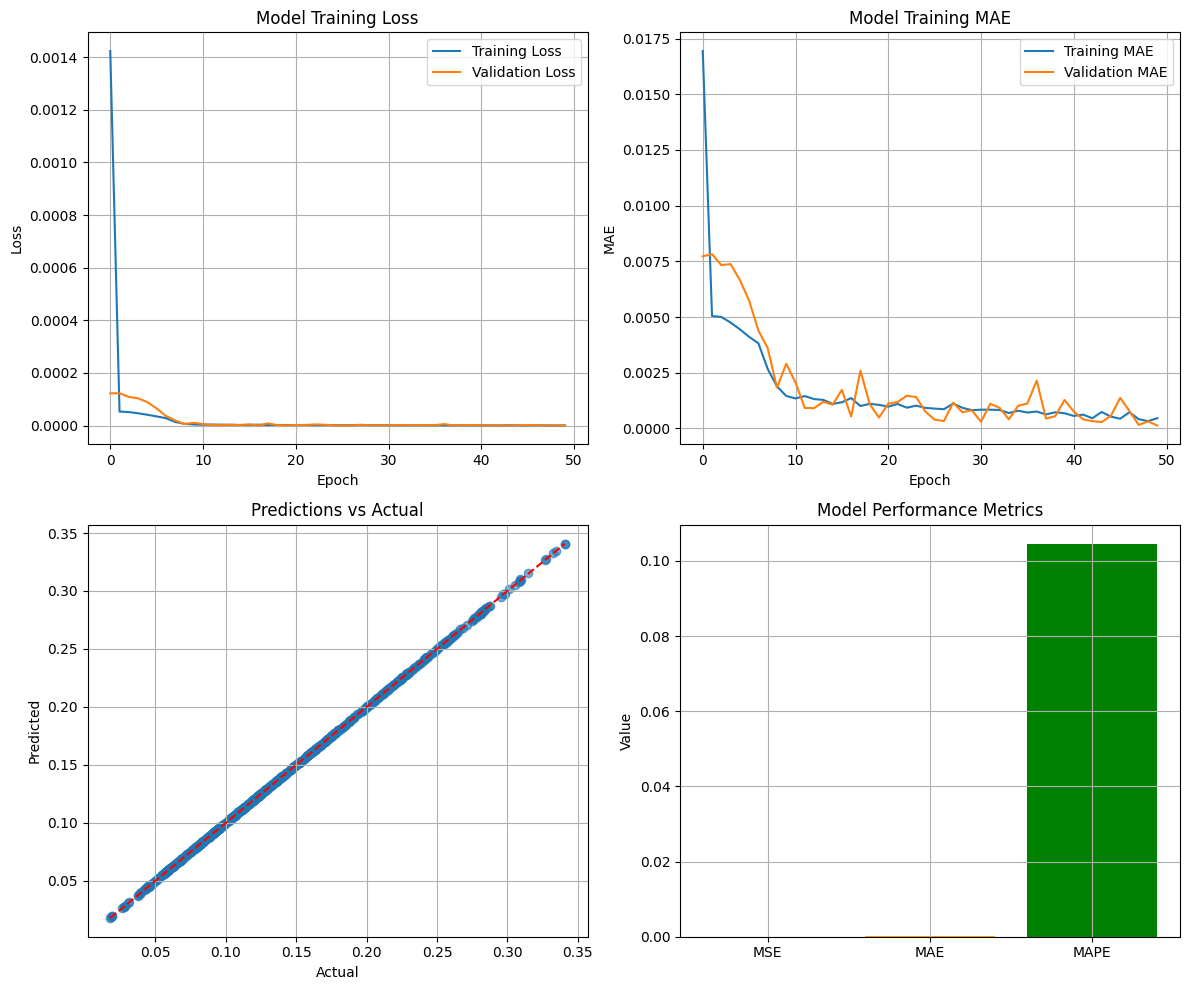

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
axes[0,0].plot(history.history['loss'], label='Training Loss')
axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
axes[0,0].set(title='Model Training Loss', xlabel='Epoch', ylabel='Loss')
axes[0,0].legend()
axes[0,0].grid(True)

# Training MAE
axes[0,1].plot(history.history['mae'], label='Training MAE')
axes[0,1].plot(history.history['val_mae'], label='Validation MAE')
axes[0,1].set(title='Model Training MAE', xlabel='Epoch', ylabel='MAE')
axes[0,1].legend()
axes[0,1].grid(True)

# Predictions vs Actual
axes[1,0].scatter(y_test_all, test_pred, alpha=0.6)
axes[1,0].plot([y_test_all.min(), y_test_all.max()], [y_test_all.min(), y_test_all.max()], 'r--')
axes[1,0].set(title='Predictions vs Actual', xlabel='Actual', ylabel='Predicted')
axes[1,0].grid(True)

# Metrics bar plot
metrics = ['MSE', 'MAE', 'MAPE']
values = [test_mse, test_mae, test_mape]
axes[1,1].bar(metrics, values, color=['skyblue', 'orange', 'green'])
axes[1,1].set(title='Model Performance Metrics', ylabel='Value')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

In [20]:
def forecast_future(model, country_data, years_ahead=8):
    last_sequence = country_data['X_test'][-1]
    forecasts = []
    current_seq = last_sequence.copy()

    for year in range(years_ahead):
        input_data = current_seq.reshape(1, current_seq.shape[0], 1)
        next_pred = model.predict(input_data, verbose=0)[0, 0]
        forecasts.append(next_pred)
        current_seq = np.append(current_seq[1:], next_pred)

    return forecasts

sample_countries = list(processed_data.keys())[:5]
forecast_years = list(range(2023, 2031))

print("Forecasting for", len(sample_countries), "countries")
print("Forecast period:", forecast_years[0], "to", forecast_years[-1])

for country_key in sample_countries:
    country_data = processed_data[country_key]

    if len(country_data['X_test']) > 0:
        try:
            forecasts = forecast_future(model, country_data)
            last_actual = country_data['y_test'][-1]

            print("\n" + country_key)
            print(f"Last actual value (2022): {last_actual:.2f}%")

            for year, forecast in zip(forecast_years, forecasts):
                print(f"  {year}: {forecast:.2f}%")

        except Exception as e:
            print("Could not generate forecast for", country_key, ":", e)

Forecasting for 5 countries
Forecast period: 2023 to 2030

afghanistan_men
Last actual value (2022): 0.23%
  2023: 0.23%
  2024: 0.23%
  2025: 0.24%
  2026: 0.25%
  2027: 0.25%
  2028: 0.26%
  2029: 0.27%
  2030: 0.27%

afghanistan_women
Last actual value (2022): 0.28%
  2023: 0.28%
  2024: 0.29%
  2025: 0.30%
  2026: 0.31%
  2027: 0.31%
  2028: 0.32%
  2029: 0.33%
  2030: 0.34%

albania_men
Last actual value (2022): 0.12%
  2023: 0.12%
  2024: 0.13%
  2025: 0.13%
  2026: 0.14%
  2027: 0.14%
  2028: 0.15%
  2029: 0.16%
  2030: 0.16%

albania_women
Last actual value (2022): 0.09%
  2023: 0.09%
  2024: 0.10%
  2025: 0.10%
  2026: 0.11%
  2027: 0.11%
  2028: 0.11%
  2029: 0.12%
  2030: 0.13%

algeria_men
Last actual value (2022): 0.17%
  2023: 0.17%
  2024: 0.17%
  2025: 0.17%
  2026: 0.18%
  2027: 0.18%
  2028: 0.18%
  2029: 0.19%
  2030: 0.19%


In [21]:
model.save('/content/drive/MyDrive/Dissertation/diabetes_lstm_model.keras')

import pickle
with open('/content/drive/MyDrive/Dissertation/lstm_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

results = {
    'model_performance': {
        'test_mse': float(test_mse),
        'test_mae': float(test_mae),
        'test_mape': float(test_mape),
        'avg_country_mse': float(avg_mse),
        'avg_country_mae': float(avg_mae),
        'avg_country_mape': float(avg_mape)
    },
    'model_info': {
        'sequence_length': seq_length,
        'test_size': test_size,
        'total_countries': successful_count,
        'training_samples': len(X_train_all),
        'test_samples': len(X_test_all),
        'epochs_trained': len(history.history['loss'])
    },
    'country_results': country_results
}

import json
with open('/content/drive/MyDrive/Dissertation/lstm_model_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("All files saved successfully!")

All files saved successfully!
